1)	Scaling <br>
나이 – MinMax <br>
총대출건수  - log1p Normalize <br>
대출건수, 대출금액 RobustScaling <br>

2)	PCA

In [1]:
#필요 라이브러리
import pandas as pd
import numpy as np

#################### Train_Test Split ######################
from sklearn.model_selection import train_test_split


#################### 성능평가 ############################
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import sklearn
#################### XGBoost ###########################
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV


################## lgbm ###########################
from lightgbm import LGBMClassifier

##################### Decision Tree #######################
from sklearn.tree import DecisionTreeClassifier

################## RandomForest ##########################
from sklearn.ensemble import RandomForestClassifier

###################### Logistic Rregression ###############
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore')

In [2]:
#모델 성능 평가 함수화
def model_assessment(test,pred):
    confusion = confusion_matrix(test, pred)
    accuracy = accuracy_score(test,pred)
    report = metrics.classification_report(test, pred, digits=2)
    
    print('accuracy', accuracy, '\n')
    print('confusion_matrix',confusion, '\n')
    print(report)

In [3]:
import pandas as pd 
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [4]:
#시각화 패키지 라이브러리
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Malgun Gothic' #한글깨짐현상방지
matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
df = pd.read_csv('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/data/Corona19_Classification_data.csv',encoding='cp949')

In [7]:
len(df)

977390

In [8]:
len(df.columns)

63

In [9]:
df_m = df

해당 데이터로 분류 모델링을 수행하기 위해서는 JOIN_KEY 속성이 배제돼야함

In [10]:
df_m.drop(columns=['JOIN_KEY','생년월일'],inplace=True)
df_m['성별']  = df_m['성별'].astype(str)
sex_onehot = pd.get_dummies(df_m['성별'])
sex_onehot.drop(columns=['1'], inplace=True)
sex_onehot = sex_onehot.rename(columns={'2':'성별'})
df_m.drop(columns=['성별'], inplace = True)
df_m = pd.concat([df_m, sex_onehot], axis=1)

In [11]:
df_m['성별'] = df_m['성별'].astype('int')

In [12]:
#연체여부 종속변수는 int로 변환
df_m['연체여부'] = df_m['연체여부'].map({'0':0,"b'1'":1})

In [40]:
연체여부 = df_m['연체여부']

# 1. 총대출금액 정규화

정규화 log normalization은 총대출금액에 아주 유의미한 차이를 보임

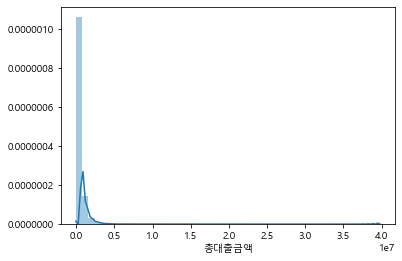

In [14]:
sns.distplot(df_m['총대출금액'])

In [15]:
df_m['총대출금액'] = np.log1p(df_m['총대출금액'])

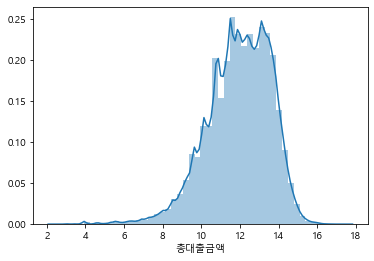

In [16]:
sns.distplot(df_m['총대출금액'])

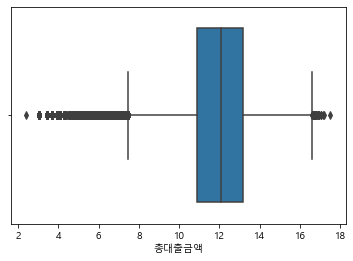

In [17]:
sns.boxplot(df_m['총대출금액'])

해당 데이터에서 정상인 케이스 비율이 전체의 약 99.65%, 채무불이행(연체)가 약 0.35%임

In [18]:
df_m['연체여부'].value_counts() / df_m['연체여부'].value_counts().sum() *100

0    99.647121
1     0.352879
Name: 연체여부, dtype: float64

In [19]:
#시각화 패키지 라이브러리
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Malgun Gothic' #한글깨짐현상방지
matplotlib.rcParams['axes.unicode_minus'] = False

Text(0.5, 1.0, '연체여부 \n (0:정상 || 1:채무불이행)')

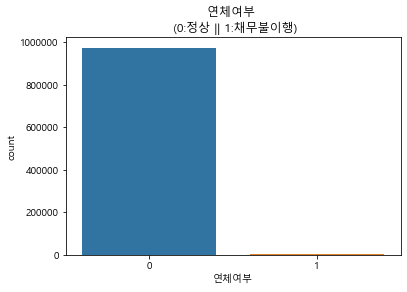

In [20]:
sns.countplot('연체여부', data = df_m)
plt.title('연체여부 \n (0:정상 || 1:채무불이행)')

# 2. Scaling의 필요성

스케일링은 모델에 영향을 주는 feature들의 데이터 간격차와 연산량을 줄이기 위해 실시

In [21]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
robust = RobustScaler()
minmax = MinMaxScaler()

## 1. 나이 - Min - max Scaling
## 2. 대출금액, 대출건수 - Robust Scaling (이상치 덜 민감)
## 3. 성별 - 스케일링 안함

In [23]:
나이 = df_m[['나이']]
성별 = df_m[['성별']]
성별 = 성별.reset_index()
성별.drop(columns=['index'], inplace=True)

In [24]:
나이_scaled = minmax.fit_transform(나이.values)
나이_scaled = pd.DataFrame(나이_scaled, columns=나이.columns)

In [25]:
나이 = 나이_scaled

In [26]:
import pickle as pkl
with open("MinMax.pkl",'wb') as outfile:
    pkl.dump(minmax,outfile)

In [33]:
기타 = df_m.drop(columns=['나이','성별','연체여부'])

In [34]:
기타.shape

(977390, 58)

In [36]:
scaled = robust.fit_transform(기타.values)
기타 = pd.DataFrame(scaled, columns=기타.columns)

In [41]:
data = pd.concat([나이,성별,기타,연체여부],axis=1)

In [44]:
len(data.columns)

61

In [46]:
len(df_m.columns)

61

In [48]:
data.to_csv('C:/Users/ksy/Desktop/개인/코로나19 팀프로젝트/시나리오2/data/Scaled_data.csv',encoding='cp949')